In [4]:
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
from func.iit_tpm import make_tpm, tpm_series, dis_mean
from func.grn_tpm import text_bn_graph, iit_tpm_cal

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

In [5]:
from tqdm import tqdm
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in tqdm(enumerate(w_axis)):
    w1 = 0.5*(1 - w)
    w2 = 1.5*(1 - w)
    ww = {
        'w_ab': w,
        'w_ba': 0,
        'w_ac': 0,
        'w_ca': w,
        'w_bc': w,
        'w_cb': 0,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

50it [01:02,  1.26s/it]


In [38]:
w = 0.2
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=100)
tpm_v

array([[2.50000000e-001, 2.50000000e-001, 2.50000000e-001, ...,
        6.62599138e-262, 6.62599138e-262, 6.62599138e-262],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.50000000e-001, 2.50000000e-001, 2.50000000e-001],
       [2.50000000e-001, 2.50000000e-001, 2.50000000e-001, ...,
        1.12700677e-157, 1.12700677e-157, 1.12700677e-157],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.50000000e-001, 2.50000000e-001, 2.50000000e-001],
       [2.50000000e-001, 2.50000000e-001, 2.50000000e-001, ...,
        1.91691202e-053, 1.91691202e-053, 1.91691202e-053],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.50000000e-001, 2.50000000e-001, 2.50000000e-001]])

In [113]:
import random
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

def tpm_series2(tpm, init_state, steps):
    init_num = int(init_state, 2)
    serie = [init_num]
    serie_str = [init_state]
    for t in range(steps):
        num = serie[t]
        probabilities = tpm[num, :]
        sample = np.random.choice(range(len(probabilities)), p=probabilities)
        serie.append(sample)
        serie_str.append(decimal_to_binary(sample, min_length=int(np.log2(len(probabilities)))))
    return serie, serie_str

def serie_plot2(tpm, mech_size, en_size, en_series, init='111'):
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm, mech_size=mech_size, en_size=en_size, dis=False)   
    strs = [decimal_to_binary(i, min_length=mech_size) for i in range(2**mech_size)] 
    long_serie = []
    init_state = init
    mark_serie = []
    mark = 0
    for en_list in en_series:
        en_state = en_list[0]
        steps = len(en_list)
        mark += steps
        mark_serie.append(mark)
        serie, serie_str = tpm_series2(tpm_dic[en_state], init_state, steps)
        init_state = serie_str[-1]
        long_serie += serie[:-1]
    return un_sys, un_en, syn, long_serie

def generate_random_sequence(n, length, seeds):
    res_ls = []
    for seed in seeds:
#         np.random.seed(seed)
#         random.seed(seed)
        result = []
        while len(result) < length:
            num = random.randint(0, n)
            if num not in result:
                result.append(num)
        res_ls.append(result)
    return res_ls

def shuffle_data(inputs, targets):
    # 生成随机索引
    indices = torch.randperm(len(inputs))
    # 根据随机索引打乱输入和目标
    shuffled_inputs = inputs[indices]
    shuffled_targets = targets[indices]
    return shuffled_inputs, shuffled_targets

seeds = [41, 42]
e_len = 2
n = 12
batch0 = (2**e_len * n - 1)
samples = batch0 * len(seeds) 
train_input = np.zeros([samples, 2])
train_target = np.zeros([samples])
en_lss = generate_random_sequence(2**e_len-1, 2**e_len, seeds)
for en_ind, en_ls0 in enumerate(en_lss):
    en_series = [[decimal_to_binary(k, min_length=e_len) for _ in range(n)] for k in en_ls0]
    n_sys, un_en, syn, long_serie = serie_plot2(tpm_v, 3, e_len, en_series, init='111')
    en_num_arr = np.array([[k for _ in range(n)] for k in en_ls0]).reshape(-1)
    long_arr = np.array(long_serie)
    data_arr = np.vstack((long_arr, en_num_arr))
    data_arr = data_arr[:, :-1].T
    train_input[en_ind*batch0:(en_ind+1)*batch0, :] = data_arr
    train_target[en_ind*batch0:(en_ind+1)*batch0] = long_arr[1:].T

    
train_input.shape, train_target.shape, syn

((94, 2), (94,), 0.3863423437037241)

In [100]:
w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=25)

e_len = 2
n = 60
def int_to_one_hot(num, size=32):
    one_hot = [0] * size
    one_hot[num] = 1
    return one_hot

def make_data(tpm_v, n, e_len, seeds):
    batch0 = (2**e_len * n - 1)
    samples = batch0 * len(seeds) 
    inputs = np.zeros([samples, 32])
    target = np.zeros([samples])
    en_lss = generate_random_sequence(2**e_len-1, 2**e_len, seeds)
    init_lss = generate_random_sequence(7, 1, seeds)
    for en_ind, en_ls0 in enumerate(en_lss):
        row_ind = en_ind * batch0
        en_series = [[decimal_to_binary(k, min_length=e_len) for _ in range(n)] for k in en_ls0]
        n_sys, un_en, syn, long_serie = serie_plot2(tpm_v, 3, e_len, en_series, init=decimal_to_binary(init_lss[0][0], min_length=3))
        en_num_arr = np.array([[k for _ in range(n)] for k in en_ls0]).reshape(-1)
        long_arr = np.array(long_serie)
        data_arr = np.vstack((long_arr, en_num_arr))
        data_arr = data_arr[:, :-1].T
        for i in range(data_arr.shape[0]):
            inputs[row_ind+i, :] = int_to_one_hot(4*data_arr[i,0]+data_arr[i,1])
        target[en_ind*batch0:(en_ind+1)*batch0] = long_arr[1:].T
    return inputs, target, syn
    
def test_syn(model):
    func = torch.nn.LogSoftmax(dim=0)
    tpm_trained = np.ones([32, 8])
    for i in range(8):
        for j in range(4):
            inputs = torch.tensor(int_to_one_hot(4*i+j)).float()
            tpm_trained[4*i+j,:] = np.exp(func(model(inputs)).data.numpy())

    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_trained, mech_size=3, en_size=2, dis=True) 
    return syn

train_input, train_target, syn0 = make_data(tpm_v, n, e_len, seeds)
test_input, test_target, syn1 = make_data(tpm_v, n=10, e_len=2, seeds=[142])
train_input.shape, test_input.shape, syn0, syn1

((4780, 32), (39, 32), 0.3863423437037241, 0.3863423437037241)

# Net

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(32, 64)
        self.relu = nn.ReLU()
        self.layer4 = nn.Linear(64, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
#         x = self.layer3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

In [115]:
w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=25)
e_len = 2
n = 60

func = torch.nn.LogSoftmax(dim=1)
L = torch.nn.NLLLoss()
seeds = [1,2,3,4,5]
num_epochs = 10000
interval = 400
seed_data = range(20)
train_losses_arr = np.zeros([len(seeds), int(num_epochs/interval)])
syn_arr = np.zeros([len(seeds), int(num_epochs/interval)])
for m,seed in enumerate(seeds):
    train_input, train_target, syn0 = make_data(tpm_v, n, e_len, seed_data)
    test_input, test_target, syn1 = make_data(tpm_v, n=60, e_len=2, seeds=[42])
    torch.manual_seed(seed)
    model = Classifier()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    input_data = torch.tensor(train_input, dtype=float).float()
    targets = torch.tensor(train_target).long()
    test_input = torch.tensor(test_input, dtype=float).float() 
    test_target = torch.tensor(test_target).long()
    test_input, test_target = shuffle_data(test_input, test_target)
    # 训练循环
    train_losses = []
    test_losses = []
    syn_ls = []

    for epoch in range(num_epochs):
        outputs = model(input_data)
        # 计算损失
        y = func(outputs)
        loss = L(y, targets)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        # 更新参数
        optimizer.step()
        # 打印损失
        if (epoch + 1) % interval == 0:
            syn_t = test_syn(model)
            test_out = model(test_input)
            y = func(test_out)
            test_loss = L(y, test_target)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            syn_ls.append(syn_t)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Syn: {syn_t}, test_loss: {test_loss.item()}')
    train_losses_arr[m, :] = train_losses
    syn_arr[m, :] = syn_ls

Epoch [400/10000], Loss: 1.5307188034057617, Syn: 0.019801016958352024, test_loss: 1.6080541610717773
Epoch [800/10000], Loss: 0.8090161681175232, Syn: 0.11054920542609457, test_loss: 0.8685957789421082
Epoch [1200/10000], Loss: 0.4594880938529968, Syn: 0.14111547223168072, test_loss: 0.45702704787254333
Epoch [1600/10000], Loss: 0.27392879128456116, Syn: 0.24852405542063286, test_loss: 0.30436545610427856
Epoch [2000/10000], Loss: 0.17585015296936035, Syn: 0.2349211641913375, test_loss: 0.17697584629058838
Epoch [2400/10000], Loss: 0.12845633924007416, Syn: 0.3215398078580022, test_loss: 0.13263866305351257
Epoch [2800/10000], Loss: 0.08997786790132523, Syn: 0.3142352185830969, test_loss: 0.1456197053194046
Epoch [3200/10000], Loss: 0.07016376405954361, Syn: 0.3656554411290078, test_loss: 0.13822366297245026
Epoch [3600/10000], Loss: 0.054079651832580566, Syn: 0.27802085270556065, test_loss: 0.10987453907728195
Epoch [4000/10000], Loss: 0.05027872323989868, Syn: 0.2898288806177193, te

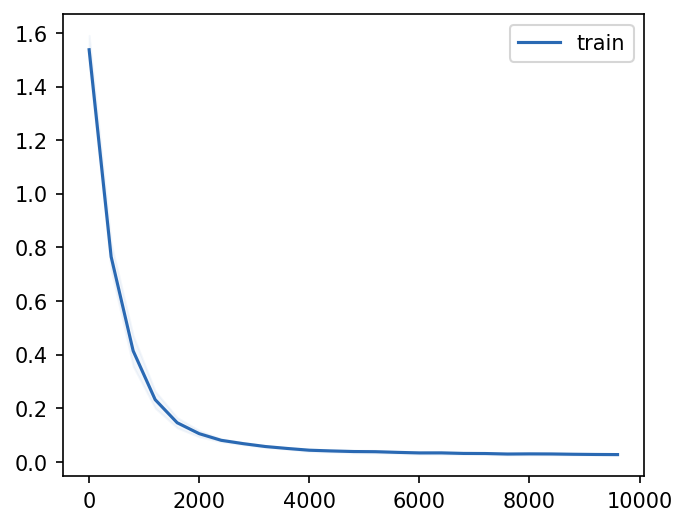

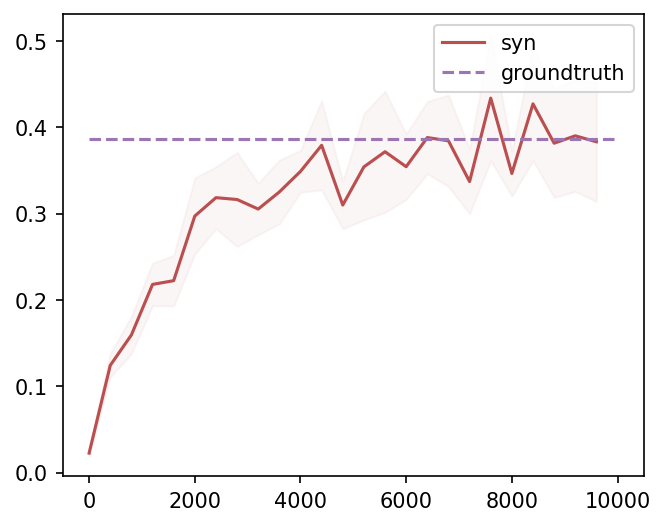

In [116]:
train_loss_mean = np.mean(train_losses_arr, axis=0)
train_loss_std = np.std(train_losses_arr, axis=0)
syn_mean = np.mean(syn_arr, axis=0)
syn_std = np.std(syn_arr, axis=0)
x_tick = [i * interval for i in range(len(train_loss_mean))]
plt.figure(figsize=(5,4),dpi=150)
plt.plot(x_tick, train_loss_mean, color=colors[1], label="train")
plt.fill_between(x_tick, train_loss_mean+train_loss_std, train_loss_mean-train_loss_std, color=colors[1], alpha=0.05)
plt.legend()
plt.show()

plt.figure(figsize=(5,4),dpi=150)
plt.plot(x_tick, syn_mean, color=colors[0], label="syn")
plt.fill_between(x_tick, syn_mean+syn_std, syn_mean-syn_std, color=colors[0], alpha=0.05)
plt.plot([0, len(train_losses)*interval], [syn0, syn1], color=colors[3], linestyle='--', label="groundtruth")
plt.legend()
plt.show()

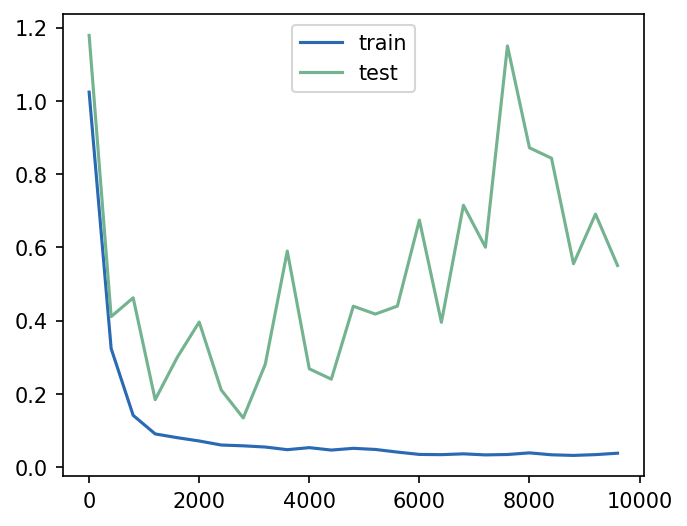

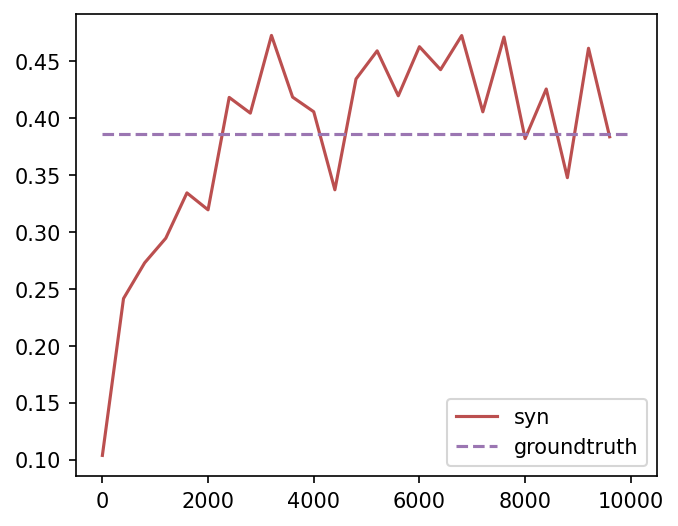

In [109]:
plt.figure(figsize=(5,4),dpi=150)
plt.plot([i * interval for i in range(len(train_losses))], train_losses, color=colors[1], label="train")
plt.plot([i * interval for i in range(len(train_losses))], test_losses, color=colors[2], label="test")
plt.legend()
plt.show()

plt.figure(figsize=(5,4),dpi=150)
plt.plot([i * interval for i in range(len(train_losses))], syn_ls, color=colors[0], label="syn")
plt.plot([0, len(train_losses)*interval], [syn0, syn1], color=colors[3], linestyle='--', label="groundtruth")
plt.legend()
plt.show()

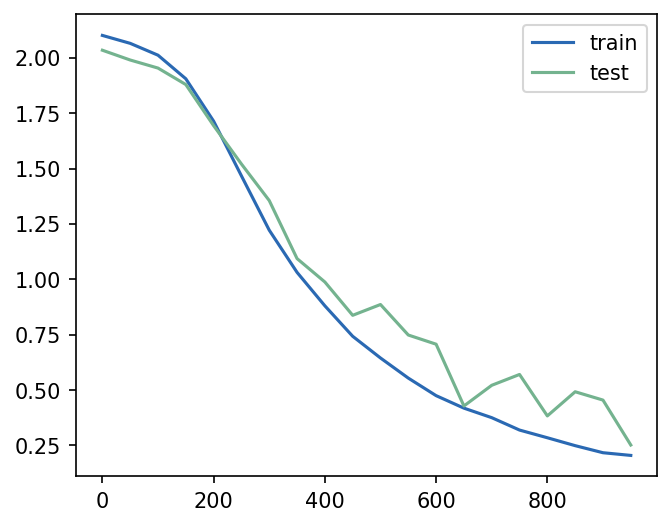

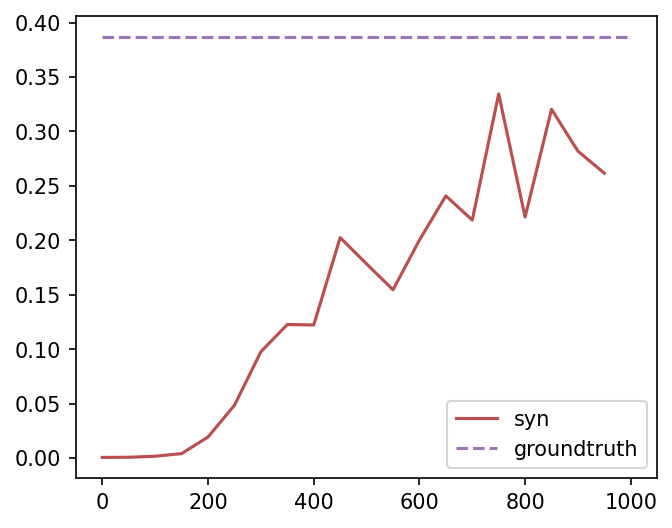

In [107]:
plt.figure(figsize=(5,4),dpi=150)
plt.plot([i * interval for i in range(len(train_losses))], train_losses, color=colors[1], label="train")
plt.plot([i * interval for i in range(len(train_losses))], test_losses, color=colors[2], label="test")
plt.legend()
plt.show()

plt.figure(figsize=(5,4),dpi=150)
plt.plot([i * interval for i in range(len(train_losses))], syn_ls, color=colors[0], label="syn")
plt.plot([0, len(train_losses)*interval], [syn0, syn1], color=colors[3], linestyle='--', label="groundtruth")
plt.legend()
plt.show()